<a href="https://colab.research.google.com/github/MehrdadJalali-AI/NodeGeneration/blob/main/CG_GAN_RDkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Invalid metal SMILES skipped: [Mo]1234(O[Mo]567(O[Mo]8([O])(O[Mo]9%10%11(O[Mo]%12%13(O[Mo]%14%15(O[Si]%16%17(OO%17)(O1)OO%16)(O[Mo](O[Cu]1O[Mo]%16%17(O[Mo@@]%18(O[Cu]O[Mo@](O%18)(O[Cu]O[Mo@@]%18(O[Mo]%19([O])(O[Mo@@](O[Cu]O%16)(O[Cu]O%19)O%18)O1)[O])O%17)[O])[O])(O8)(O%11)O[Mo](O6)([O])(O[Mo]1(O[Mo](O[Cu]([O])[O])(O[Mo](O%12)(O%10)(O3)[O])(O[Mo]([O])(O1)(O%13)O%14)O4)([O])(O5)O7)O%15)[O])(O9)[O])[O])O2)[O])[O]
Invalid metal SMILES skipped: [Zn].F[Si](F)(F)(F)(F)F
Invalid metal SMILES skipped: [Na].[BH4].[Na].[BH4]
Invalid metal SMILES skipped: [Cu].F[Si](F)(F)(F)(F)F.[Cu].F[Si](F)(F)(F)(F)F
Invalid metal SMILES skipped: [Al](C)(C)(C)C(C)(C)C.[Li].C[Al]C(C)(C)C.[Li].[CH2].[H].[CH3]
Invalid metal SMILES skipped: [Al]1([O])(O[C]O[Al]2(O)(O[C]O1)(O[C]O[Al]1(O[C]O[Al]3(O[C]O[Al]4(O[C]O[Al](O[C])(O[C]O4)[O])(O)(O[C]O3)O)(O[C]O1)O)O[C]O2)O)(O[C])O
Invalid metal SMILES skipped: [Ag][Ag]1[Ag]([O])ON(O1)[O].O1[N]2(OO2)O1.[Ag][Ag].[O].[O]N=O.[O].[Ag]
Invalid metal SMILES skippe

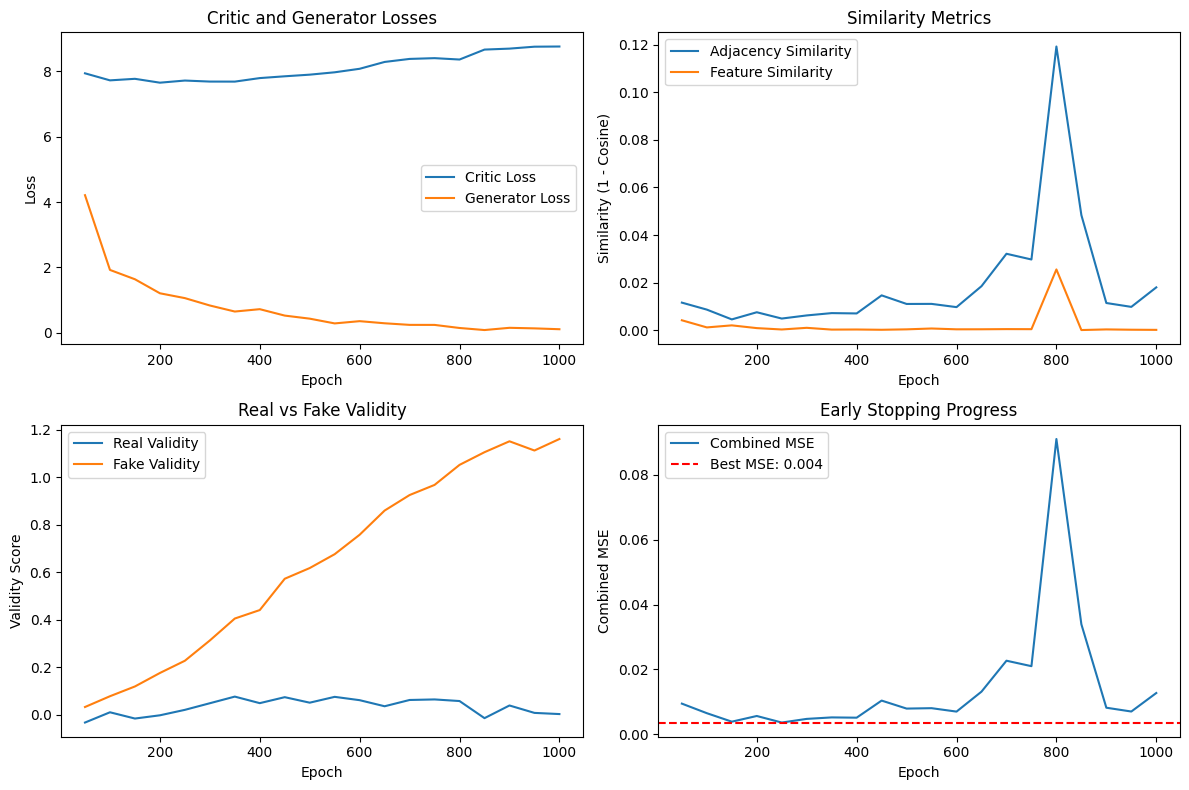

/tmp/ipykernel_742/1230430244.py:359: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("best_generator.pth"))


New MOF 1:
Metal SMILES: [O][U]([O])(O[C]=O)(O[C]=O)(O[C]=O)O[C]=O
Linker SMILES: N#CCCCCCCCCC#N
Tanimoto Similarity: 1.000
Closest Adjacency MSE: 0.044
Closest Features MSE: 0.048
Saved structures as mof_1_metal.png and mof_1_linker.png
New MOF 2:
Metal SMILES: [Cu].[Cu]
Linker SMILES: N#CCCCCCC#N
Tanimoto Similarity: 1.000
Closest Adjacency MSE: 0.254
Closest Features MSE: 0.073
New MOF 3:
Metal SMILES: [Co]
Linker SMILES: N#C[C](C#N)C#N
Tanimoto Similarity: 1.000
Closest Adjacency MSE: 0.191
Closest Features MSE: 0.004
New MOF 4:
Metal SMILES: [Co]
Linker SMILES: N#CC(=O)C#N
Tanimoto Similarity: 1.000
Closest Adjacency MSE: 0.142
Closest Features MSE: 0.018
New MOF 5:
Metal SMILES: [Ag]
Linker SMILES: N#C[C](C#N)C#N
Tanimoto Similarity: 1.000
Closest Adjacency MSE: 0.007
Closest Features MSE: 0.001
New MOF 6:
Metal SMILES: [Ag]
Linker SMILES: N#CCCCCC#N
Tanimoto Similarity: 1.000
Closest Adjacency MSE: 0.008
Closest Features MSE: 0.001
New MOF 7:
Metal SMILES: [Ag][Ag]
Linker SMILES

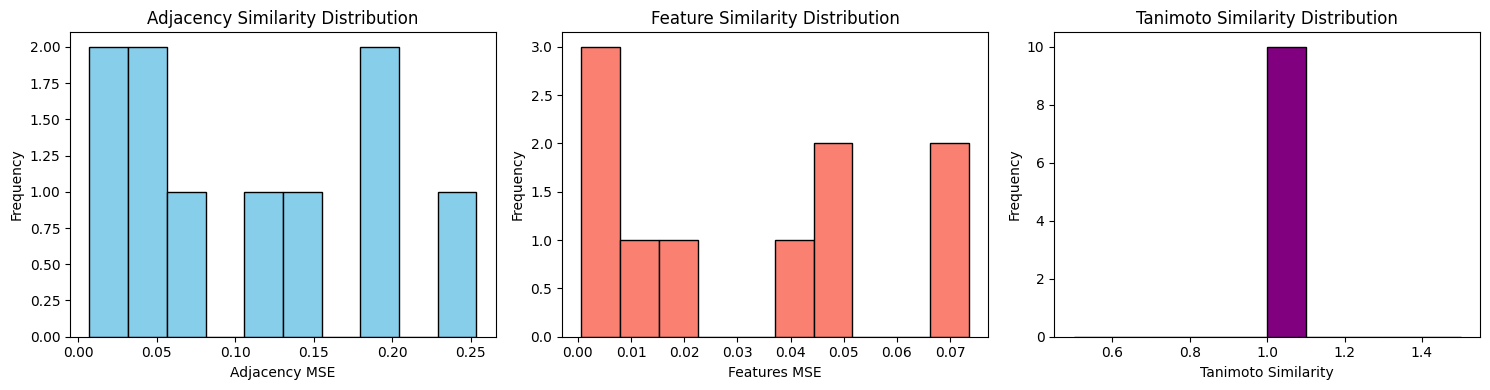

ValueError: cannot reshape array of size 25600 into shape (32,32)

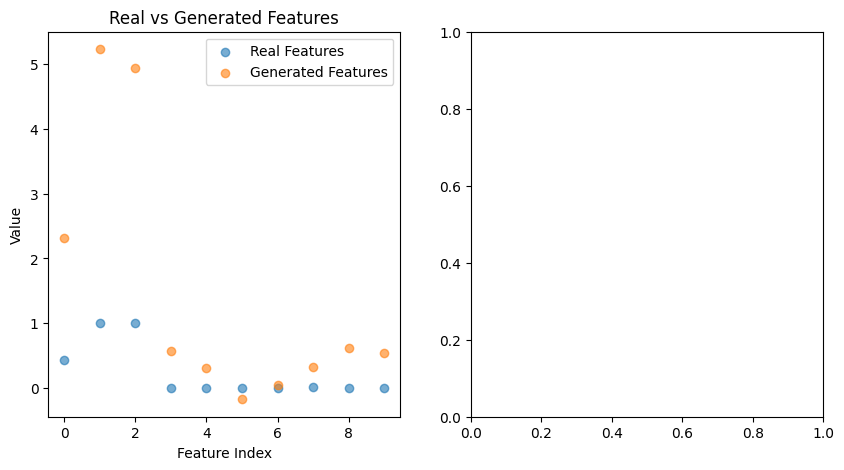

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import spectral_norm
from sklearn.preprocessing import LabelEncoder
import json
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Data Loading and Preprocessing ---
mof_data = pd.read_excel("Book1.xlsx")
adj_data = pd.read_csv("adjacency_matrix.csv")

numeric_cols = [
    'max_metal_coordination_n', 'n_sbu_point_of_extension', 'n_linker_point_of_extension',
    'n_channel', 'void_fraction', 'asa (A^2)', 'av (A^3)', 'pld (A)', 'lcd (A)', 'lfpd (A)'
]
features = mof_data[numeric_cols].values
refcodes = mof_data['Refcode'].values
metal_smiles = mof_data['metal_sbu_smile'].values
linker_smiles = mof_data['linker_smile'].values
adj_matrix_full = adj_data.drop(columns=['Refcode']).values
adj_refcodes = adj_data['Refcode'].values

def validate_and_canonicalize_smiles(smiles_list, label):
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi, sanitize=False)
        if mol:
            try:
                Chem.SanitizeMol(mol)
                canonical_smi = Chem.MolToSmiles(mol, canonical=True)
                valid_smiles.append(canonical_smi)
            except:
                print(f"Invalid {label} SMILES skipped: {smi}")
        else:
            print(f"Invalid {label} SMILES skipped: {smi}")
    return valid_smiles

metal_smiles_clean = validate_and_canonicalize_smiles(metal_smiles, "metal")
linker_smiles_clean = validate_and_canonicalize_smiles(linker_smiles, "linker")

valid_indices = [i for i, (ms, ls) in enumerate(zip(metal_smiles, linker_smiles))
                 if ms in metal_smiles_clean and ls in linker_smiles_clean]
mof_data = mof_data.iloc[valid_indices]
features = features[valid_indices]
refcodes = refcodes[valid_indices]
metal_smiles = np.array(metal_smiles_clean)[[metal_smiles_clean.index(ms) for ms in mof_data['metal_sbu_smile']]]
linker_smiles = np.array(linker_smiles_clean)[[linker_smiles_clean.index(ls) for ls in mof_data['linker_smile']]]

valid_refcodes = set(refcodes)
adj_valid_indices = [i for i, ref in enumerate(adj_refcodes) if ref in valid_refcodes]
adj_data = adj_data.iloc[adj_valid_indices]
adj_matrix = adj_data.drop(columns=['Refcode']).values
adj_refcodes = adj_data['Refcode'].values

assert len(features) == len(adj_matrix), f"Size mismatch: features ({len(features)}) vs adj_matrix ({len(adj_matrix)})"

features_min, features_max = features.min(axis=0), features.max(axis=0)
features = (features - features_min) / (features_max - features_min)
adj_mean, adj_std = adj_matrix.mean(), adj_matrix.std()
adj_matrix = (adj_matrix - adj_mean) / adj_std

le_metal = LabelEncoder()
le_linker = LabelEncoder()
metal_encoded = le_metal.fit_transform(metal_smiles)
linker_encoded = le_linker.fit_transform(linker_smiles)

features_tensor = torch.FloatTensor(features).to(device)
adj_matrix_tensor = torch.FloatTensor(adj_matrix).to(device)
metal_tensor = torch.FloatTensor(metal_encoded).unsqueeze(1).to(device)
linker_tensor = torch.FloatTensor(linker_encoded).unsqueeze(1).to(device)

# --- Model Definitions ---
class Generator(nn.Module):
    def __init__(self, latent_dim, metal_vocab_size, linker_vocab_size, embedding_dim, adj_dim, feature_dim):
        super(Generator, self).__init__()
        self.metal_embedding = nn.Embedding(metal_vocab_size, embedding_dim)
        self.linker_embedding = nn.Embedding(linker_vocab_size, embedding_dim)
        self.condition_processor = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(128)
        )
        self.shared = nn.Sequential(
            nn.Linear(latent_dim + 128, 512),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(1024),
            nn.Dropout(0.3)
        )
        self.adj_branch = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(2048),
            nn.Dropout(0.3),
            nn.Linear(2048, 4096),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(4096),
            nn.Dropout(0.3),
            nn.Linear(4096, adj_dim),
        )
        self.feature_branch = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(256),
            nn.Linear(256, feature_dim),
        )

    def forward(self, z, metal_cond, linker_cond):
        metal_cond = metal_cond.squeeze().long()
        linker_cond = linker_cond.squeeze().long()
        if metal_cond.dim() == 0:
            metal_cond = metal_cond.unsqueeze(0)
        if linker_cond.dim() == 0:
            linker_cond = linker_cond.unsqueeze(0)
        metal_emb = self.metal_embedding(metal_cond)
        linker_emb = self.linker_embedding(linker_cond)
        cond = torch.cat([metal_emb, linker_emb], dim=1)
        cond_out = self.condition_processor(cond)
        combined = torch.cat([z, cond_out], dim=1)
        shared_out = self.shared(combined)
        adj_output = self.adj_branch(shared_out) * adj_std + adj_mean
        feature_output = self.feature_branch(shared_out)
        return adj_output, feature_output

class Critic(nn.Module):
    def __init__(self, feature_dim, adj_dim, condition_dim):
        super(Critic, self).__init__()
        self.feature_processor = nn.Sequential(
            spectral_norm(nn.Linear(feature_dim, 128)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(128, 64)),
            nn.LeakyReLU(0.2)
        )
        self.adj_processor = nn.Sequential(
            spectral_norm(nn.Linear(adj_dim, 256)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(256, 64)),
            nn.LeakyReLU(0.2)
        )
        self.condition_processor = nn.Sequential(
            spectral_norm(nn.Linear(condition_dim, 32)),
            nn.LeakyReLU(0.2)
        )
        self.combined = nn.Sequential(
            spectral_norm(nn.Linear(64 + 64 + 32, 32)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(32, 1)),
            nn.ConstantPad1d((0, 0), 50)
        )

    def forward(self, features, adj, condition):
        noise = torch.randn_like(features) * 0.1
        feat_out = self.feature_processor(features + noise)
        adj_out = self.adj_processor(adj)
        cond_out = self.condition_processor(condition)
        combined = torch.cat([feat_out, adj_out, cond_out], dim=1)
        return self.combined(combined)

# --- Utility Functions ---
def compute_gradient_penalty(critic, real_features, real_adj, fake_features, fake_adj, real_cond, fake_cond):
    batch_size = real_features.size(0)
    alpha = torch.rand(batch_size, 1).to(device)
    interpolates_features = alpha * real_features + (1 - alpha) * fake_features
    interpolates_adj = alpha * real_adj + (1 - alpha) * fake_adj
    interpolates_cond = alpha * real_cond + (1 - alpha) * fake_cond

    interpolates_features.requires_grad_(True)
    interpolates_adj.requires_grad_(True)
    interpolates_cond.requires_grad_(True)
    critic_output = critic(interpolates_features, interpolates_adj, interpolates_cond)

    gradients = torch.autograd.grad(
        outputs=critic_output,
        inputs=[interpolates_features, interpolates_adj, interpolates_cond],
        grad_outputs=torch.ones_like(critic_output).to(device),
        create_graph=True,
        retain_graph=True
    )
    gradients_features, gradients_adj, gradients_cond = gradients
    gradient_norm = torch.sqrt(
        gradients_features.norm(2, dim=1)**2 + gradients_adj.norm(2, dim=1)**2 + gradients_cond.norm(2, dim=1)**2
    )
    return ((gradient_norm - 1) ** 2).mean() * 10

def adjacency_similarity(fake_adj, real_adj):
    return 1 - cosine_similarity(fake_adj, real_adj, dim=1).mean()

def feature_similarity(fake_features, real_features):
    return 1 - cosine_similarity(fake_features, real_features, dim=1).mean()

# --- Hyperparameters ---
latent_dim = 100
feature_dim = features.shape[1]
adj_dim = adj_matrix.shape[1]
condition_dim = 2
embedding_dim = 64
metal_vocab_size = len(le_metal.classes_)
linker_vocab_size = len(le_linker.classes_)
batch_size = 64
epochs = 1000
n_critic = 1
mse_weight_adj = 25.0
mse_weight_features = 50.0

# --- Model Initialization ---
generator = Generator(latent_dim, metal_vocab_size, linker_vocab_size, embedding_dim, adj_dim, feature_dim).to(device)
critic = Critic(feature_dim, adj_dim, condition_dim).to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
c_optimizer = optim.Adam(critic.parameters(), lr=0.000002, betas=(0.5, 0.999))

# --- DataLoader ---
dataset = TensorDataset(features_tensor, adj_matrix_tensor, metal_tensor, linker_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- Training Setup ---
best_mse = float('inf')
patience = 100
patience_counter = 0
c_losses, g_losses, adj_sims, feat_sims, real_validities, fake_validities, combined_mses = [], [], [], [], [], [], []

# --- Training Loop ---
for epoch in range(epochs):
    for i, (real_features, real_adj, real_metal, real_linker) in enumerate(dataloader):
        batch_size = real_features.size(0)
        real_features, real_adj = real_features.to(device), real_adj.to(device)
        real_condition = torch.cat([real_metal, real_linker], dim=1).to(device)

        c_optimizer.zero_grad()
        real_validity = critic(real_features, real_adj, real_condition)
        z = torch.randn(batch_size, latent_dim).to(device) * 0.5
        noise_metal = torch.randn(batch_size, 1).to(device) * 0.1
        noise_linker = torch.randn(batch_size, 1).to(device) * 0.1
        fake_condition = torch.cat([real_metal + noise_metal, real_linker + noise_linker], dim=1)
        fake_adj, fake_features = generator(z, real_metal, real_linker)
        fake_validity = critic(fake_features, fake_adj.detach(), real_condition)
        gradient_penalty = compute_gradient_penalty(critic, real_features, real_adj, fake_features, fake_adj,
                                                    real_condition, fake_condition)
        c_loss = torch.mean(fake_validity) - torch.mean(real_validity) + gradient_penalty
        c_loss.backward(retain_graph=True)
        c_optimizer.step()

        if i % n_critic == 0:
            g_optimizer.zero_grad()
            fake_validity = critic(fake_features, fake_adj, real_condition)
            adj_similarity_loss = adjacency_similarity(fake_adj, real_adj)
            feature_similarity_loss = feature_similarity(fake_features, real_features)
            g_loss = -torch.mean(fake_validity) + mse_weight_adj * adj_similarity_loss + mse_weight_features * feature_similarity_loss
            g_loss.backward()
            g_optimizer.step()

    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            generator.eval()
            z = torch.randn(1, latent_dim).to(device) * 0.5
            random_idx = np.random.randint(0, len(metal_tensor))
            test_metal = metal_tensor[random_idx:random_idx + 1]
            test_linker = linker_tensor[random_idx:random_idx + 1]
            generated_adj, generated_features = generator(z, test_metal, test_linker)
            real_adj_sample = adj_matrix_tensor[random_idx:random_idx + 1]
            real_features_sample = features_tensor[random_idx:random_idx + 1]
            mse_adj = adjacency_similarity(generated_adj, real_adj_sample).item()
            mse_features = feature_similarity(generated_features, real_features_sample).item()
            mean_real_validity = torch.mean(real_validity).item()
            mean_fake_validity = torch.mean(fake_validity).item()
            combined_mse = 0.7 * mse_adj + 0.3 * mse_features

            c_losses.append(c_loss.item())
            g_losses.append(g_loss.item())
            adj_sims.append(mse_adj)
            feat_sims.append(mse_features)
            real_validities.append(mean_real_validity)
            fake_validities.append(mean_fake_validity)
            combined_mses.append(combined_mse)

            print(f"Epoch [{epoch + 1}/{epochs}] | C Loss: {c_loss.item():.3f} | G Loss: {g_loss.item():.3f} | "
                  f"MSE Adj: {mse_adj:.3f} | MSE Features: {mse_features:.3f} | "
                  f"Real Validity: {mean_real_validity:.3f} | Fake Validity: {mean_fake_validity:.3f} | "
                  f"Best MSE: {best_mse:.3f}")
            generator.train()

            if combined_mse < best_mse:
                best_mse = combined_mse
                patience_counter = 0
                torch.save(generator.state_dict(), "best_generator.pth")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1} with Best MSE: {best_mse:.3f}")
                    break

# --- Plot Training Progress ---
epochs_range = range(50, epoch + 2, 50)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, c_losses, label="Critic Loss")
plt.plot(epochs_range, g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Critic and Generator Losses")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_range, adj_sims, label="Adjacency Similarity")
plt.plot(epochs_range, feat_sims, label="Feature Similarity")
plt.xlabel("Epoch")
plt.ylabel("Similarity (1 - Cosine)")
plt.title("Similarity Metrics")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs_range, real_validities, label="Real Validity")
plt.plot(epochs_range, fake_validities, label="Fake Validity")
plt.xlabel("Epoch")
plt.ylabel("Validity Score")
plt.title("Real vs Fake Validity")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs_range, combined_mses, label="Combined MSE")
plt.axhline(y=best_mse, color="r", linestyle="--", label=f"Best MSE: {best_mse:.3f}")
plt.xlabel("Epoch")
plt.ylabel("Combined MSE")
plt.title("Early Stopping Progress")
plt.legend()

plt.tight_layout()
plt.savefig("training_progress.png")
plt.show()

# --- Generate New MOFs with RDKit ---
generator.load_state_dict(torch.load("best_generator.pth"))
generator.eval()
num_new_mofs = 10
new_mofs = []
adj_mse_list, feat_mse_list, tanimoto_sim_list = [], [], []

real_metal_mols = [Chem.MolFromSmiles(smi) for smi in metal_smiles]
real_linker_mols = [Chem.MolFromSmiles(smi) for smi in linker_smiles]
real_metal_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in real_metal_mols if mol]
real_linker_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in real_linker_mols if mol]

for i in range(num_new_mofs):
    z = torch.randn(1, latent_dim).to(device) * 0.5
    random_metal_idx = np.random.randint(0, metal_vocab_size)
    random_linker_idx = np.random.randint(0, linker_vocab_size)
    new_metal = torch.tensor([random_metal_idx], dtype=torch.float32).unsqueeze(1).to(device)
    new_linker = torch.tensor([random_linker_idx], dtype=torch.float32).unsqueeze(1).to(device)

    generated_adj, generated_features = generator(z, new_metal, new_linker)
    metal_smiles_gen = le_metal.inverse_transform([random_metal_idx])[0]
    linker_smiles_gen = le_linker.inverse_transform([random_linker_idx])[0]

    metal_mol = Chem.MolFromSmiles(metal_smiles_gen)
    linker_mol = Chem.MolFromSmiles(linker_smiles_gen)
    if not metal_mol or not linker_mol:
        print(f"Invalid SMILES generated for MOF {i + 1}, skipping...")
        continue

    gen_metal_fp = AllChem.GetMorganFingerprintAsBitVect(metal_mol, 2, nBits=2048)
    gen_linker_fp = AllChem.GetMorganFingerprintAsBitVect(linker_mol, 2, nBits=2048)
    metal_tanimoto = max([Chem.DataStructs.TanimotoSimilarity(gen_metal_fp, fp) for fp in real_metal_fps])
    linker_tanimoto = max([Chem.DataStructs.TanimotoSimilarity(gen_linker_fp, fp) for fp in real_linker_fps])
    avg_tanimoto = (metal_tanimoto + linker_tanimoto) / 2
    tanimoto_sim_list.append(avg_tanimoto)

    closest_adj_mse = min([adjacency_similarity(generated_adj, adj_matrix_tensor[j:j + 1]).item()
                           for j in range(len(adj_matrix_tensor))])
    closest_features_mse = min([feature_similarity(generated_features, features_tensor[j:j + 1]).item()
                                for j in range(len(features_tensor))])
    adj_mse_list.append(closest_adj_mse)
    feat_mse_list.append(closest_features_mse)

    new_mofs.append({
        "metal_smiles": metal_smiles_gen,
        "linker_smiles": linker_smiles_gen,
        "adjacency_matrix": generated_adj.detach().cpu().numpy().tolist(),
        "features": generated_features.detach().cpu().numpy().tolist(),
        "closest_adj_mse": closest_adj_mse,
        "closest_features_mse": closest_features_mse,
        "tanimoto_similarity": avg_tanimoto,
        "metal_mol_weight": Descriptors.MolWt(metal_mol),
        "linker_mol_weight": Descriptors.MolWt(linker_mol)
    })

    print(f"New MOF {i + 1}:")
    print(f"Metal SMILES: {metal_smiles_gen}")
    print(f"Linker SMILES: {linker_smiles_gen}")
    print(f"Tanimoto Similarity: {avg_tanimoto:.3f}")
    print(f"Closest Adjacency MSE: {closest_adj_mse:.3f}")
    print(f"Closest Features MSE: {closest_features_mse:.3f}")

    if i == 0:
        Draw.MolToFile(metal_mol, f"mof_{i + 1}_metal.png", size=(200, 200))
        Draw.MolToFile(linker_mol, f"mof_{i + 1}_linker.png", size=(200, 200))
        print(f"Saved structures as mof_{i + 1}_metal.png and mof_{i + 1}_linker.png")

# Save generated MOFs
with open("new_mofs_expanded.json", "w") as f:
    json.dump(new_mofs, f)
print("New MOFs saved to 'new_mofs_expanded.json'.")

# --- Plot Similarity Distributions ---
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.hist(adj_mse_list, bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Adjacency MSE")
plt.ylabel("Frequency")
plt.title("Adjacency Similarity Distribution")

plt.subplot(1, 3, 2)
plt.hist(feat_mse_list, bins=10, color="salmon", edgecolor="black")
plt.xlabel("Features MSE")
plt.ylabel("Frequency")
plt.title("Feature Similarity Distribution")

plt.subplot(1, 3, 3)
plt.hist(tanimoto_sim_list, bins=10, color="purple", edgecolor="black")
plt.xlabel("Tanimoto Similarity")
plt.ylabel("Frequency")
plt.title("Tanimoto Similarity Distribution")

plt.tight_layout()
plt.savefig("similarity_distributions.png")
plt.show()

# --- Plot Real vs Generated Comparison ---
real_features_sample = features_tensor[random_idx:random_idx + 1].detach().cpu().numpy()
real_adj_sample = adj_matrix_tensor[random_idx:random_idx + 1].detach().cpu().numpy()
generated_features_np = generated_features.detach().cpu().numpy()
generated_adj_np = generated_adj.detach().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(range(feature_dim), real_features_sample[0], label="Real Features", alpha=0.6)
plt.scatter(range(feature_dim), generated_features_np[0], label="Generated Features", alpha=0.6)
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.title("Real vs Generated Features")
plt.legend()

plt.subplot(1, 2, 2)
# Pad or truncate to 1024 (32x32) for visualization
target_size = 1024  # Nearest square size > 1000
side_length = int(np.sqrt(target_size))
if generated_adj_np.size < target_size:
    padded_adj = np.pad(generated_adj_np, (0, target_size - generated_adj_np.size), mode='constant')
else:
    padded_adj = generated_adj_np[:target_size]
plt.imshow(padded_adj.reshape(side_length, side_length), cmap="viridis", interpolation="none")
plt.colorbar()
plt.title("Generated Adjacency Matrix")

plt.tight_layout()
plt.savefig("real_vs_generated_comparison.png")
plt.show()